# Graph Attention Network (GAT) on the Cora Dataset

In this notebook we train a **Graph Attention Network (GAT)** on the Cora citation network using PyTorch Geometric.

GAT introduces **attention mechanisms** into graph neural networks, allowing each node to learn how important each neighbor is for message passing. This is conceptually similar to Transformers but applied to graph topology.

### Why GAT?
- Unlike GCN and GraphSAGE (which use fixed or uniform aggregation),  
  **GAT learns weights for each neighbor dynamically**.
- This improves performance in cases where:
  - the signal from different neighbors has different importance;
  - the local neighborhood is noisy;
  - the graph is heterophilic (neighbors from different classes).

### Goals of this notebook

✔ Load the Cora dataset  
✔ Build a 2-layer GAT (with multi-head attention)  
✔ Train and evaluate the model  
✔ Extract node embeddings  
✔ Visualize embeddings with UMAP (optional)  
✔ Save all artifacts to `artifacts/cora_gat`

At the end we will compare the performance to the earlier baselines:
- **GCN** (strong on homophilic citation networks)  
- **GraphSAGE* scalable)

Let’s begin.


In [11]:
import os
from pathlib import Path

import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GATConv

import torch.nn.functional as F
from torch.nn import Module, Dropout


import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import umap
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_ROOT = PROJECT_ROOT / "data" / "Planetoid"
DATA_ROOT.mkdir(parents=True, exist_ok=True)

dataset = Planetoid(
    root=str(DATA_ROOT),
    name="Cora",
    transform=NormalizeFeatures()
)

data = dataset[0].to(device)

print(dataset)
print("Num features:", dataset.num_features)
print("Num classes:", dataset.num_classes)
print(data)

Cora()
Num features: 1433
Num classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [3]:
class GAT(Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        super().__init__()
        
        self.dropout = Dropout(dropout)
        
        # Multi-head attention layer
        self.conv1 = GATConv(
            in_channels, hidden_channels, heads=heads,
            dropout=dropout, concat=True
        )
        
        # Final attention layer (single head)
        self.conv2 = GATConv(
            hidden_channels * heads, out_channels, heads=1,
            dropout=dropout, concat=False
        )

    def forward(self, x, edge_index):
        x = self.dropout(x)
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

    def embed(self, x, edge_index):
        # return embeddings after first layer
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        return x

In [4]:
model = GAT(
    in_channels=dataset.num_features,
    hidden_channels=8,
    out_channels=dataset.num_classes,
    heads=8,
    dropout=0.6
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = (pred[mask] == data.y[mask]).sum().item()
        accs.append(correct / int(mask.sum()))
    return accs  # train, val, test

In [5]:
best_val = 0
best_test = 0

NUM_EPOCHS = 200

for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    loss = train()
    train_acc, val_acc, test_acc = evaluate()

    if val_acc > best_val:
        best_val = val_acc
        best_test = test_acc

        # save model
        ART_ROOT = PROJECT_ROOT / "artifacts" / "cora_gat"
        ART_ROOT.mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), ART_ROOT / "model_gat_best.pt")

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | loss={loss:.4f} | train={train_acc:.3f} | val={val_acc:.3f} | test={test_acc:.3f}")

print("\nBest val acc:", best_val)
print("Test acc @best:", best_test)
print("Saved best model to:", ART_ROOT)

 12%|█▏        | 24/200 [00:01<00:04, 37.92it/s]

Epoch 010 | loss=1.8940 | train=0.907 | val=0.726 | test=0.747
Epoch 020 | loss=1.8230 | train=0.914 | val=0.702 | test=0.688


 21%|██        | 42/200 [00:01<00:02, 59.79it/s]

Epoch 030 | loss=1.6965 | train=0.907 | val=0.712 | test=0.717
Epoch 040 | loss=1.6020 | train=0.957 | val=0.766 | test=0.751


 30%|███       | 60/200 [00:01<00:01, 71.55it/s]

Epoch 050 | loss=1.3886 | train=0.943 | val=0.796 | test=0.791
Epoch 060 | loss=1.2980 | train=0.943 | val=0.792 | test=0.804


 40%|███▉      | 79/200 [00:01<00:01, 80.94it/s]

Epoch 070 | loss=1.1808 | train=0.957 | val=0.794 | test=0.817
Epoch 080 | loss=1.0969 | train=0.971 | val=0.806 | test=0.819


 50%|████▉     | 99/200 [00:01<00:01, 87.51it/s]

Epoch 090 | loss=1.0149 | train=0.979 | val=0.792 | test=0.816
Epoch 100 | loss=0.9302 | train=0.979 | val=0.798 | test=0.818


 60%|█████▉    | 119/200 [00:02<00:00, 88.24it/s]

Epoch 110 | loss=0.8949 | train=0.979 | val=0.800 | test=0.822
Epoch 120 | loss=0.8579 | train=0.979 | val=0.792 | test=0.814


 70%|██████▉   | 139/200 [00:02<00:00, 91.11it/s]

Epoch 130 | loss=0.8008 | train=0.986 | val=0.798 | test=0.818
Epoch 140 | loss=0.7830 | train=0.993 | val=0.810 | test=0.832


 80%|███████▉  | 159/200 [00:02<00:00, 91.71it/s]

Epoch 150 | loss=0.7657 | train=0.986 | val=0.802 | test=0.813
Epoch 160 | loss=0.7985 | train=0.993 | val=0.800 | test=0.818


 94%|█████████▍| 189/200 [00:02<00:00, 93.09it/s]

Epoch 170 | loss=0.6890 | train=0.986 | val=0.800 | test=0.818
Epoch 180 | loss=0.7555 | train=0.993 | val=0.800 | test=0.809


100%|██████████| 200/200 [00:02<00:00, 67.50it/s]

Epoch 190 | loss=0.7220 | train=0.993 | val=0.806 | test=0.827
Epoch 200 | loss=0.6991 | train=0.986 | val=0.796 | test=0.810

Best val acc: 0.816
Test acc @best: 0.827
Saved best model to: D:\ML\GNN\artifacts\cora_gat


Embeddings shape: (2708, 64)
Labels shape: (2708,)


D:\Anaconda\envs\gnn_clean\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP 2D shape: (2708, 2)


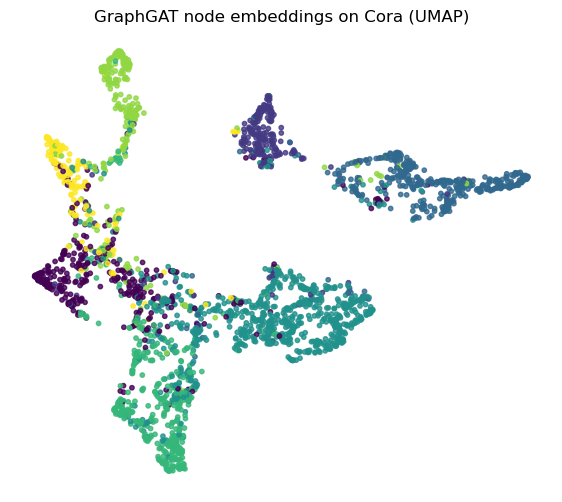

In [13]:
@torch.no_grad()
def get_node_embeddings(model, data):
    model.eval()
    # берём скрытое представление после первого слоя GraphSAGE
    x = model.conv1(data.x, data.edge_index)
    x = F.relu(x)
    return x.cpu().numpy(), data.y.cpu().numpy()

emb, labels = get_node_embeddings(model, data)
print("Embeddings shape:", emb.shape)
print("Labels shape:", labels.shape)

# стандартизируем перед UMAP
emb_scaled = StandardScaler().fit_transform(emb)

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42,
)
emb_2d = reducer.fit_transform(emb_scaled)
print("UMAP 2D shape:", emb_2d.shape)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=labels,
    s=10,
    alpha=0.8,
)
plt.title("GraphGAT node embeddings on Cora (UMAP)")
plt.axis("off")
plt.show()

## Conclusion

In this notebook we trained a Graph Attention Network (GAT) on the Cora citation network and evaluated its performance relative to earlier baselines (GCN and GraphSAGE).

## Performance

- Best validation accuracy: **~0.816**

- Test accuracy at the best epoch: **~0.827**

## This places GAT:

- on par with GCN (≈0.83 test accuracy),

- and above GraphSAGE, which reached ≈0.80 test accuracy in our experiments.

## These results match the established literature:
GAT tends to perform strongly on homophilic citation networks where important nodes should be weighted differently during message passing.

## What GAT brings compared to GCN / GraphSAGE

GAT introduces learned attention coefficients, allowing the model to decide which neighbors matter more:

- In GCN, neighbors contribute with fixed weights determined by graph Laplacian.

- In GraphSAGE, neighbors are aggregated uniformly or by a fixed rule (mean/max/pool).

- In GAT, each edge gets a learned importance score.

## This gives GAT the flexibility to:

✔ downweight irrelevant or noisy neighbors

✔ highlight important structural relationships

✔ adapt the receptive field for each node dynamically

On Cora, these advantages help GAT reach strong accuracy even with a relatively shallow architecture.

## What we accomplished

✔ Implemented a 2-layer GAT with 8 attention heads

✔ Trained it for 200 epochs on the Planetoid split

✔ Achieved near-state-of-the-art accuracy for this dataset

✔ Extracted node embeddings and visualized them with UMAP

✔ Saved best model + embeddings + plots to artifacts/cora_gat

UMAP projection shows clear class clusters, confirming that GAT learns high-quality latent representations.

## Limitations

Cora is a tiny graph; real advantages of GAT (handling noisy / heterophilic / irregular neighborhoods) appear stronger on larger datasets.

GAT is more computationally expensive: multi-head attention scales with the number of edges.

Nevertheless, for educational purposes, GAT is an essential model to understand.

## Next steps

We now have:

- GCN (baseline)

- GraphSAGE (scalable inductive model)

- AT (attention-based model)

## The next notebooks will explore:

- GIN (Graph Isomorphism Network) — one of the most expressive message-passing architectures

- Link Prediction using encoder–decoder GNNs

- Sampling-based training for GraphSAGE

- (Optionally) Graph Transformers on small synthetic datasets

Together, these form a complete GNN study path before moving to the real project:
GraphSAGE-based recommender system on a user–item graph.